# Import Python Libraries

In [1]:
!pip install control

In [2]:
import control
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Define transfer function of the system
s = control.tf('s')

# MIMO - (Wood and Berry, 1973)


Example 18.1 - Seborg, Dale E., Thomas F. Edgar, and Duncan A. Mellichamp. 2011. Process Dynamics and Control. 3rd ed. Hoboken, NJ: John Wiley & Sons.

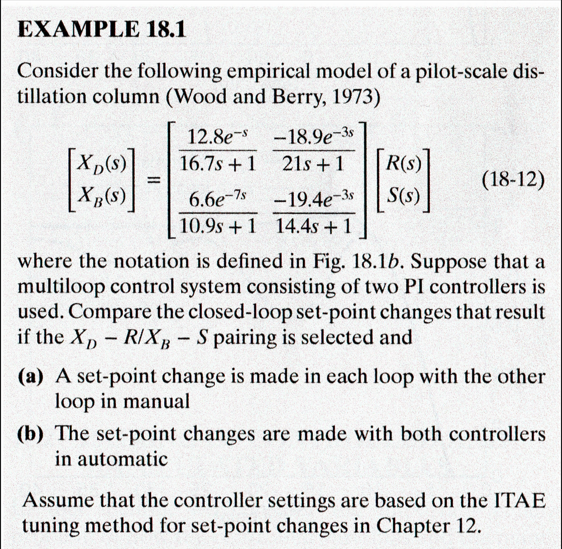

## Transfer Functions

In [4]:
# Defining the transfer functions of the Wood and Berry model without delays
G11_FO = control.tf([12.8], [16.7, 1])
G12_FO = control.tf([-18.9], [21, 1])
G21_FO = control.tf([6.6], [10.9, 1])
G22_FO = control.tf([-19.4], [14.4, 1])

In [5]:
# Fifth Order Padé Approximation for the delays
# High Order because we need more precision here!
num1, den1 = control.pade(1, n=5)  # 1-second delay
num3, den3 = control.pade(3, n=5)  # 3-seconds delay
num7, den7 = control.pade(7, n=5)  # 7-seconds delay

In [6]:
# Applying delays to the transfer functions
G11_delay = control.tf(num1, den1)
G12_delay = control.tf(num3, den3)
G21_delay = control.tf(num7, den7)
G22_delay = control.tf(num3, den3)

In [7]:
G11 = control.series(G11_FO,G11_delay)
G12 = control.series(G12_FO,G12_delay)
G21 = control.series(G21_FO,G21_delay)
G22 = control.series(G22_FO,G22_delay)

## PI Controllers

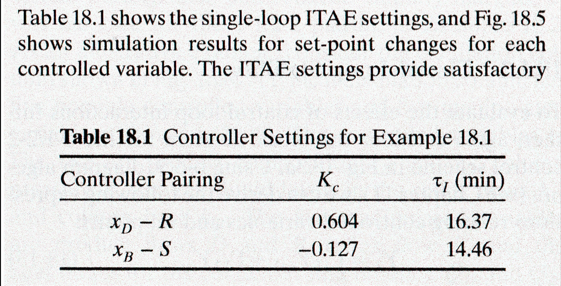

In [8]:
# Parameters for the PI controller pairing Xd - R
Kc = 0.604
ti = 16.37

# Define transfer function of the PI Controller
PI1 = Kc*(1 + (1/(ti*s)))

In [9]:
# Parameters for the PI controller pairing Xb - S
Kc = -0.127
ti = 14.46

# Define transfer function of the PID Controller
PI2 = Kc*(1 + (1/(ti*s)))

## Decoupling Control System


In [10]:
Kp21  = control.dcgain(G21)
Kp21

6.6

In [11]:
Kp22  = control.dcgain(G22)
Kp22

-19.4

In [12]:
T21 = -Kp21/Kp22
T21 = control.tf(T21,1)
T21

TransferFunction(array([0.34020619]), array([1]))

In [13]:
Kp12  = control.dcgain(G12)
Kp12

-18.9

In [14]:
Kp11  = control.dcgain(G11)
Kp11

12.8

In [15]:
T12 = -Kp12/Kp11
T12 = control.tf(T12,1)
T12

TransferFunction(array([1.4765625]), array([1]))

## Switches (Put Control Manual or Automatic)

In [16]:
def Switches(S1, S2):
  global switch1, switch2
  if S1 == "Manual":
    switch1 = control.tf(0, 1)
  if S1 == "Automatic":
    switch1 = control.tf(1, 1)

  if S2 == "Manual":
    switch2 = control.tf(0, 1)
  if S2 == "Automatic":
    switch2 = control.tf(1, 1)

## Define Inputs and Ouputs Names

In [17]:
def DefineNames():
  global summer1, summer2
  global switch1, switch2
  global feedback1, feedback2
  global G11, G12, G21, G22, PI1, PI2
  global T21, T12
  global summer1decoupling, summer2decoupling


  switch1 = control.tf(switch1, inputs='Y1', outputs='switch1out')
  switch2 = control.tf(switch2, inputs='Y2', outputs='switch2out')
  feedback1 = control.summing_junction(['Ysp1', '-switch1out'], 'E1') # E1 = Ysp1 - switch1out
  feedback2 = control.summing_junction(['Ysp2', '-switch2out'], 'E2') # E2 = Ysp2 - switch2out
  PI1 = control.tf(PI1, inputs='E1', outputs='PI1out')
  PI2 = control.tf(PI2, inputs='E2', outputs='PI2out')

  T21 = control.tf(T21, inputs='PI1out', outputs='T21out')
  T12 = control.tf(T12, inputs='PI2out', outputs='T12out')

  summer1decoupling = control.summing_junction(['PI1out', 'T12out'], 'summer1decouplingout') # summer1decouplingout = PI1out + T12out
  summer2decoupling = control.summing_junction(['PI2out', 'T21out'], 'summer2decouplingout') # summer2decouplingout = PI2out + T21out

  G11 = control.tf(G11, inputs='summer1decouplingout', outputs='G11out')
  G12 = control.tf(G12, inputs='summer2decouplingout', outputs='G12out')
  G21 = control.tf(G21, inputs='summer1decouplingout', outputs='G21out')
  G22 = control.tf(G22, inputs='summer2decouplingout', outputs='G22out')

  summer1 = control.summing_junction(['G11out', 'G12out'], 'Y1') # Y1 = G11_out + G12_out
  summer2 = control.summing_junction(['G21out', 'G22out'], 'Y2') # Y2 = G21_out + G22_out


## Blocks Interconnections

In [18]:
def BlocksInter(S1, S2):
  global sys
  Switches(S1, S2)
  DefineNames()

  sys = control.interconnect([switch1, switch2,
                              feedback1, feedback2,
                              PI1, PI2,
                              T21, T12,
                              summer1decoupling, summer2decoupling,
                              G11, G12, G21, G22,
                              summer1, summer2],
                              inplist=['Ysp1', 'Ysp2'], outlist=['Y1', 'Y2'])

# Step Responses

In [19]:
t = np.linspace(0, 60, 601)

In [20]:
BlocksInter("Automatic", "Automatic")
_, yu1_Automatic_Automatic = control.step_response(sys, t, input=0, squeeze=True)

In [21]:
BlocksInter("Automatic", "Automatic")
_, yu2_Automatic_Automatic = control.step_response(sys, t, input=1, squeeze=True)

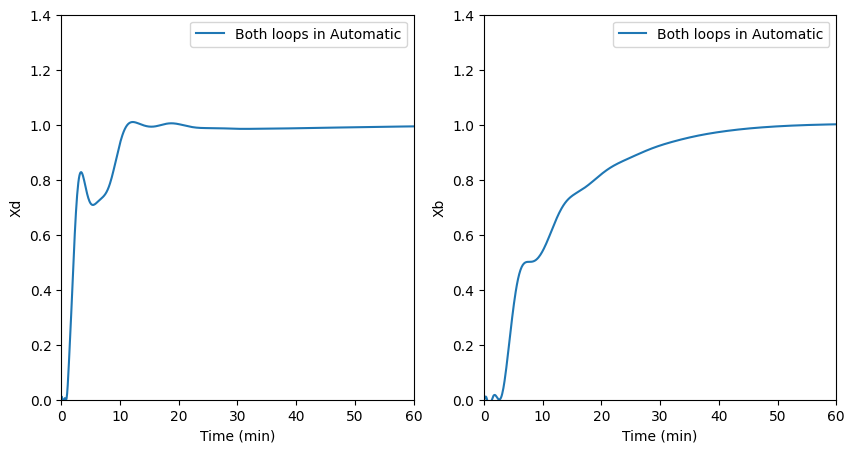

In [22]:
plt.figure(1, figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(t, yu1_Automatic_Automatic[0], label='Both loops in Automatic')
plt.xlabel('Time (min)')
plt.ylabel('Xd')
plt.xlim([0, 60])
plt.ylim([0, 1.4])
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(t, yu2_Automatic_Automatic[1], label='Both loops in Automatic')
plt.xlabel('Time (min)')
plt.ylabel('Xb')
plt.xlim([0, 60])
plt.ylim([0, 1.4])
plt.legend()